#ENGR 8140 - Advanced Deep Learning & Engineering Applications
## Assignment 2 - Image Classification
In this assignment, you will practice on image classification using the CIFAR-10 dataset.
The codes for data downloading and processing are provided below. Note the train dataset is further split into train_ds and val_ds and three dataloaders (i.e., train_loader, val_loader, and test_loader) are created for training, validation, and testing, respectively.

You will need to complete the following tasks:

(1) Code the MnasNet-A1 (shown below, ref: https://arxiv.org/abs/1807.11626) in PyTorch by following the similar coding style as the examples shown in "NB6_ModernCNNs.ipynb". Specifically, you will need to "modularize" your codes, i.e., define proper "classes" and/or "functions" for different blocks as shown in Figure 7 below (e.g., MBConv3, MBConv6, and SepConv) and then use them to construct your model architecture.

(2) Train the MnasNet-A1 using CIFAR-10.

(3) Evaluate your model and report performance on the test dataset.


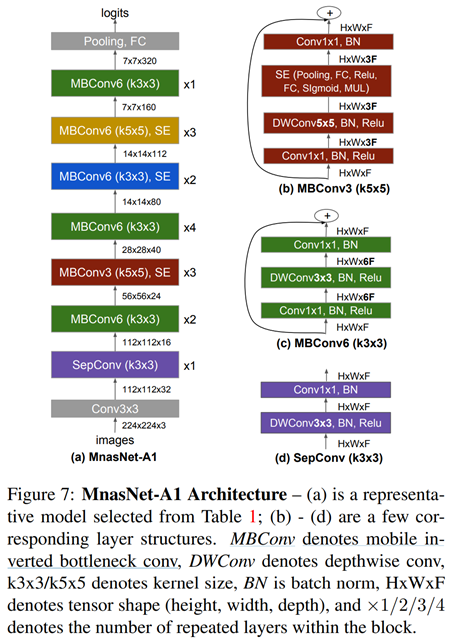

In [1]:
!nvidia-smi
!pip install accelerate -U
!pip show accelerate
!pip install git+https://github.com/huggingface/accelerate
!pip install ptflops

Fri Feb 23 19:41:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

from torchvision.models import resnet50
from ptflops import get_model_complexity_info

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm
import torch.optim as optim

import os

# # Accelerate parts
# from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
# from accelerate.utils import set_seed # reproducability across devices

In [3]:
batch_size = 128
maxEpoch = 1

In [4]:
def get_dataloaders(batch_size):
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

    cf10_transforms = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    train = CIFAR10(root='./data', train=True, download=True, transform=cf10_transforms)
    test = CIFAR10(root='./data', train=False, download=True, transform=cf10_transforms)
    
    ##################################################################################
    print(train.classes)
    
    torch.manual_seed(42)
    val_size = 5000
    train_size = len(train) - val_size

    ##################################################################################
    
    # 'random_split' is a PyTorch function that randomly splits a dataset into non-overlapping new datasets
    # The lengths of the splits are provided as a list: [train_size, val_size]
    train_ds, val_ds = random_split(train, [train_size, val_size])
    len(train_ds), len(val_ds)
    
    ##################################################################################
    
    # Create a DataLoader for the training dataset
    # shuffle=True will shuffle the dataset before each epoch
    # num_workers=2 will use two subprocesses for data loading
    # pin_memory=True will copy Tensors into CUDA pinned memory before returning them
    train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test, batch_size, num_workers=2, pin_memory=True)
    
    return train_loader, val_loader, test_loader, train.classes

In [5]:
# # Only execute if necessary

# train_loader, val_loader, test_loader, classes = get_dataloaders(batch_size)

# for images, _ in train_loader:
#     print('images.shape:', images.shape)
#     plt.figure(figsize=(32,32))
#     plt.axis('off')
#     plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
#     break

# # make_grid() arranges images into a grid
# permute() changes the order of tensor dimensions to fit what imshow expects (height, width, channels)

## Your codes go here:
### (1) Define the model

In [6]:
# Define the Separable Convolution block
class SepConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=kernel_size//2, groups=in_channels)
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)
        # Batch normalization
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # Apply depthwise convolution, followed by pointwise convolution, then batch normalization, then ReLU activation
        return F.relu(self.bn(self.pointwise(self.depthwise(x))))

# Define the Mobile Inverted Bottleneck Convolution (MBConv) block
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor, kernel_size, stride):
        super().__init__()
        # The number of output channels for the expansion phase
        hidden_dim = in_channels * expansion_factor
        # Expansion phase (1x1 convolution)
        self.expand = nn.Conv2d(in_channels, hidden_dim, 1)
        # Depthwise convolution phase
        self.depthwise = SepConv(hidden_dim, hidden_dim, kernel_size)
        # Squeeze phase (1x1 convolution)
        self.squeeze = nn.Conv2d(hidden_dim, out_channels, 1)

    def forward(self, x):
        # Apply expansion, followed by ReLU activation
        x = F.relu(self.expand(x))
        # Apply depthwise convolution
        x = self.depthwise(x)
        # Apply squeeze phase
        return self.squeeze(x)

# Define the MnasNet-A1 model
class MnasNetA1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Initial separable convolution
        self.initial_conv = SepConv(3, 32, 3)
        # Sequence of MBConv blocks
        self.blocks = nn.Sequential(
            MBConv(32, 16, 1, 3, 1),
            MBConv(16, 24, 6, 3, 2),
            MBConv(24, 24, 6, 3, 1),
            MBConv(24, 40, 6, 5, 2),
            MBConv(40, 40, 6, 5, 1),
            MBConv(40, 80, 6, 5, 2),
            MBConv(80, 80, 6, 5, 1),
            MBConv(80, 96, 6, 5, 1),
            MBConv(96, 96, 6, 5, 1),
            MBConv(96, 192, 6, 5, 2),
            MBConv(192, 192, 6, 5, 1),
            MBConv(192, 320, 6, 3, 1),
        )
        # Final separable convolution
        self.final_conv = SepConv(320, 1280, 3)
        # Fully connected layer for class prediction
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        # Apply initial convolution
        x = self.initial_conv(x)
        # Apply MBConv blocks
        x = self.blocks(x)
        # Apply final convolution
        x = self.final_conv(x)
        # Global average pooling
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        # Class prediction
        return self.fc(x)

### (2) Train the model using train and val datasets

cuda


100%|██████████| 170498071/170498071 [00:02<00:00, 58555671.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Epoch 1/1: 100%|██████████| 352/352 [06:17<00:00,  1.07s/batch, accuracy=0.239, loss=2.02]


Epoch 1/1, Loss: 0.015795424758063423, Accuracy: 0.23913333333333334, 'Validation Accuracy: 29.04%'
Finished Training


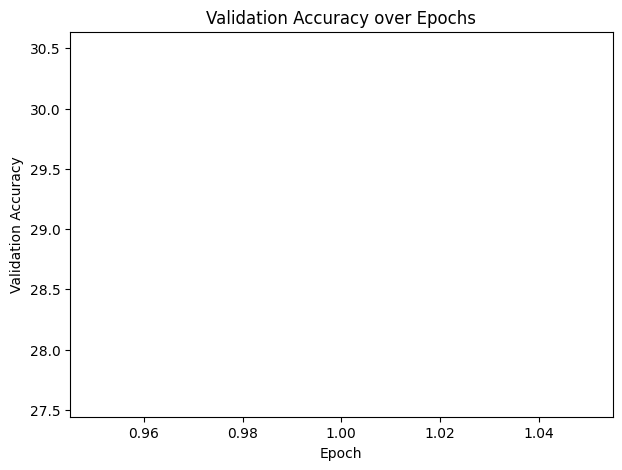

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Build the DataLoaders
train_loader, val_loader, test_loader, classes = get_dataloaders(batch_size)

# Initialize the model, loss function, optimizer, and scheduler
model = MnasNetA1(len(classes)).to(device)  # Adjust the number of classes based on your dataset
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce learning rate by a factor of 0.1 every 10 epochs

# Very important to use DataParallel to use multiple GPUs
model = nn.DataParallel(model)

# Plot accuracy over epochs
plt.figure(figsize=(7, 5))
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
# plt.show()

# List to store accuracy for each epoch
accuracy_list = []

# Training loop
for epoch in range(maxEpoch):  # Loop over the dataset multiple times
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Use tqdm to create a progress bar for the training loop
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{maxEpoch}", unit="batch") as progress_bar:
        for i, data in enumerate(progress_bar):
            # Get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data[0].to(accelerator.device), data[1].to(accelerator.device)
            inputs, labels = data[0].to(device), data[1].to(device)

            ########################################################################################
            # Training the model

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step() 

            ########################################################################################   

            # Update statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix(loss=total_loss / (i+1), accuracy=correct_predictions / total_samples)

    # Validation
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    train_accuracy = correct_predictions / total_samples

    loss = total_loss / total_samples

    # Optionally, you can print or log other metrics at the end of each epoch
    print(f"Epoch {epoch+1}/{maxEpoch}, Loss: {loss}, Accuracy: {train_accuracy}, 'Validation Accuracy: {accuracy:.2f}%'")

    plt.plot(range(1, epoch+2), accuracy_list)
    plt.draw()
    
print('Finished Training')

### (3) Evaluate the model and report performance using the test dataset


Finished Predictions
Accuracy of the network on the test images: 29 %


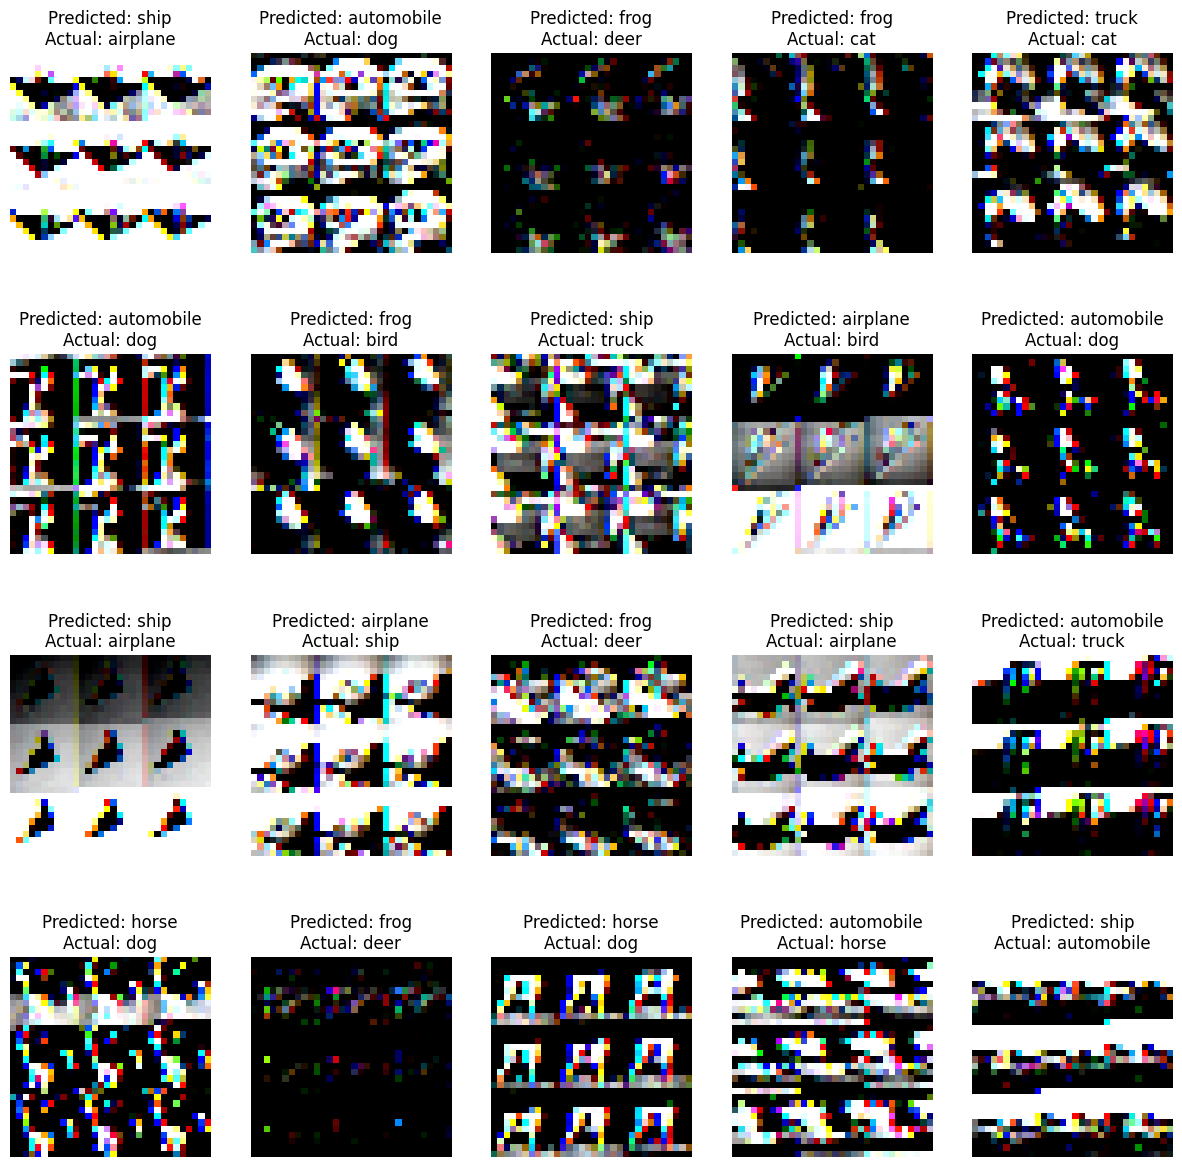

In [8]:
# Switch model to evaluation mode
model.eval()

# Lists to store wrongly predicted images and labels
wrong_images = []
wrong_labels = []
predicted_labels = []
correct = 0
total = 0

# No need to track gradients for prediction, so wrap in no_grad to save memory
with torch.no_grad():
    # Loop over all batches in the test_loader
    for data in test_loader:
        # Move the images and labels to the device (GPU or CPU)
        images, labels = data[0].to(device), data[1].to(device)
        # Pass the images through the model to get the outputs
        outputs = model(images)
        # Get the predicted class for each image by finding the index of the maximum value in the outputs
        _, predicted = torch.max(outputs.data, 1)
        # Increment the total count by the number of images in the current batch
        total += labels.size(0)
        # Increment the correct count by the number of images that were correctly classified
        correct += (predicted == labels).sum().item()
        
        # Compare the predicted labels with the actual labels, resulting in a boolean tensor where True indicates a wrong prediction
        wrong_preds = (predicted != labels)
        # Extend the wrong_images list with the images that were wrongly predicted
        wrong_images.extend(images[wrong_preds].tolist())
        # Extend the wrong_labels list with the actual labels of the images that were wrongly predicted
        wrong_labels.extend(labels[wrong_preds].tolist())
        # Extend the predicted_labels list with the predicted labels of the images that were wrongly predicted
        predicted_labels.extend(predicted[wrong_preds].tolist())

print('Finished Predictions')
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

# Use list comprehension to map the numerical class indices to class names
wrong_labels_txt = [classes[i] for i in wrong_labels]
predicted_labels_txt = [classes[i] for i in predicted_labels]

# Select 20 random indices from the list of wrong predictions
indices = np.random.choice(len(wrong_images), 20)

# Plot the images
fig, axes = plt.subplots(4, 5, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    # Convert the image data to a 28x28 array
    img = np.array(wrong_images[indices[i]]).reshape(32, 32, 3)
    # Plot the image
    ax.imshow(img)
    # Set the title to the predicted label and the actual label
    ax.set_title(f'Predicted: {predicted_labels_txt[indices[i]]}\nActual: {wrong_labels_txt[indices[i]]}')
    # Remove the axis
    ax.axis('off')

plt.show()

In [9]:
# Use list comprehension to map the numerical class indices to class names
wrong_labels_txt = [classes[i] for i in wrong_labels]
predicted_labels_txt = [classes[i] for i in predicted_labels]

### Histogram

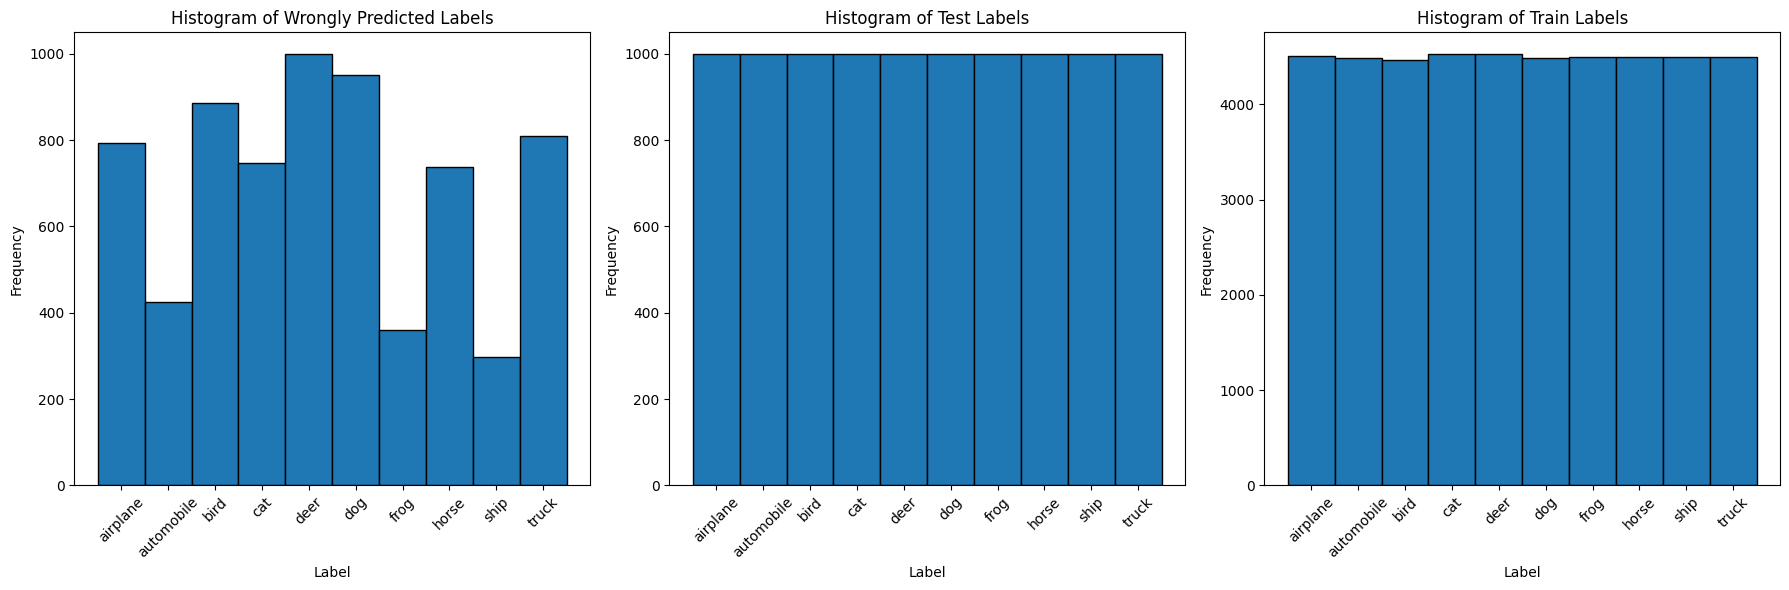

In [10]:
test_labels = []
for _, labels in test_loader:
    test_labels.extend(labels.tolist())

train_labels = []
for _, labels in train_loader:
    train_labels.extend(labels.tolist())

# Convert the lists of predicted and actual labels to numpy arrays
wrong_labels_np = np.array(wrong_labels)
test_labels_np = np.array(test_labels)
train_labels_np = np.array(train_labels)

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create a histogram of the wrong labels in the first subplot
axes[0].hist(wrong_labels_np, bins=np.arange(wrong_labels_np.min(), wrong_labels_np.max()+2) - 0.5, edgecolor='black')
axes[0].set_title('Histogram of Wrongly Predicted Labels')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(len(classes)))
axes[0].set_xticklabels(classes, rotation=45)

# Create a histogram of the test labels in the second subplot
axes[1].hist(test_labels_np, bins=np.arange(test_labels_np.min(), test_labels_np.max()+2) - 0.5, edgecolor='black')
axes[1].set_title('Histogram of Test Labels')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(range(len(classes)))
axes[1].set_xticklabels(classes, rotation=45)

# Create a histogram of the train labels in the third subplot
axes[2].hist(train_labels_np, bins=np.arange(train_labels_np.min(), train_labels_np.max()+2) - 0.5, edgecolor='black')
axes[2].set_title('Histogram of Train Labels')
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Frequency')
axes[2].set_xticks(range(len(classes)))
axes[2].set_xticklabels(classes, rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [11]:
# Create a DataFrame
summary_df = pd.DataFrame({
    "epoch": maxEpoch,
    "accuracy": accuracy_list,
    "batch_size": batch_size,
    "loss": total_loss,
    "wrong_predictions": len(wrong_images),
})

print(summary_df)

# Save the results to a CSV file
if os.path.isfile('model_performance.csv'):
    summary_df.to_csv('model_performance.csv', index=True, mode='a', header=False)
else:
    summary_df.to_csv('model_performance.csv', index=False, mode='a', header=True)

   epoch  accuracy  batch_size        loss  wrong_predictions
0      1     29.04         128  710.794114               7010
